<a href="https://colab.research.google.com/github/dnrghks5583/Way-that-set-threshold-for-setting-PMD/blob/main/caltech101_resnet32_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [2]:
from __future__ import absolute_import
from __future__ import division
from __future__ import print_function

from tensorflow.keras.layers import Dense, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation
from tensorflow.keras.layers import AveragePooling2D, Input
from tensorflow.keras.layers import Flatten, add
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, LearningRateScheduler
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.utils import to_categorical
from keras.models import load_model
import numpy as np
import os
import math
import tensorflow as tf

# training parameters
batch_size = 32 # orig paper trained all networks with batch_size=128
epochs = 100
num_classes = 102
data_augmentation = True

# subtracting pixel mean improves accuracy
subtract_pixel_mean = True

# Model parameter
# ----------------------------------------------------------------------------
#           |      | 200-epoch | Orig Paper| 200-epoch | Orig Paper| sec/epoch
# Model     |  n   | ResNet v1 | ResNet v1 | ResNet v2 | ResNet v2 | GTX1080Ti
#           |v1(v2)| %Accuracy | %Accuracy | %Accuracy | %Accuracy | v1 (v2)
# ----------------------------------------------------------------------------
# ResNet20  | 3 (2)| 92.16     | 91.25     | -----     | -----     | 35 (---)
# ResNet32  | 5(NA)| 92.46     | 92.49     | NA        | NA        | 50 ( NA)
# ResNet44  | 7(NA)| 92.50     | 92.83     | NA        | NA        | 70 ( NA)
# ResNet56  | 9 (6)| 92.71     | 93.03     | 93.01     | NA        | 90 (100)
# ResNet110 |18(12)| 92.65     | 93.39+-.16| 93.15     | 93.63     | 165(180)
# ResNet164 |27(18)| -----     | 94.07     | -----     | 94.54     | ---(---)
# ResNet1001| (111)| -----     | 92.39     | -----     | 95.08+-.14| ---(---)
# ---------------------------------------------------------------------------
n = 5

# model version
# orig paper: version = 1 (ResNet v1), 
# improved ResNet: version = 2 (ResNet v2)
version = 1
path = '/content/gdrive/My Drive/caltech101_pickle'
image_size = (128, 128)
input_shape = (128, 128, 3)
num_classes = 102

In [3]:
import gzip
import pickle

os.chdir(path)

with gzip.open('caltech101_x_trainData_128.pickle', 'rb') as f:
    x_train = pickle.load(f)
    
with gzip.open('caltech101_x_testData_128.pickle', 'rb') as f:
    x_test = pickle.load(f)
    
with gzip.open('caltech101_y_trainData_128.pickle', 'rb') as f:
    y_train = pickle.load(f)
    
with gzip.open('caltech101_y_testData_128.pickle', 'rb') as f:
    y_test = pickle.load(f)

In [4]:
if version == 1:
    depth = n * 6 + 2
elif version == 2:
    depth = n * 9 + 2

# model name, depth and version
model_type = 'ResNet%dv%d' % (depth, version)

# input image dimensions.
input_shape = x_train.shape[1:]

# normalize data.
x_train = x_train.astype('float32') / 255
x_test = x_test.astype('float32') / 255

# if subtract pixel mean is enabled
if subtract_pixel_mean:
    x_train_mean = np.mean(x_train, axis=0)
    x_train -= x_train_mean
    x_test -= x_train_mean

print('Model_Type : ' , model_type)
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')
print('y_train shape:', y_train.shape)
# convert class vectors to binary class matrices.
#y_train = to_categorical(y_train, num_classes)
#y_test = to_categorical(y_test, num_classes)

Model_Type :  ResNet32v1
x_train shape: (7316, 128, 128, 3)
7316 train samples
1829 test samples
y_train shape: (7316, 102)


In [5]:
model_path = '/content/gdrive/My Drive/caltech101/CALTECH-101_ResNet32v1_model.142.h5'
model = tf.keras.models.load_model(model_path) # load model

#model_path = '/content/gdrive/My Drive/caltech101/CALTECH-101_ResNet56v1_model.138.h5'
#model = tf.keras.models.load_model(model_path) # load model

In [6]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 128, 128, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 128, 128, 16) 448         input_1[0][0]                    
__________________________________________________________________________________________________
batch_normalization (BatchNorma (None, 128, 128, 16) 64          conv2d[0][0]                     
__________________________________________________________________________________________________
activation (Activation)         (None, 128, 128, 16) 0           batch_normalization[0][0]        
______________________________________________________________________________________________

In [7]:
y_pred = model.predict(x_test)
model.evaluate(x_test, y_test)

58/58 [==============================] - 8s 118ms/step - loss: 1.5656 - acc: 0.7731


[1.5656101703643799, 0.7731000781059265]

In [8]:
import tensorflow

cce = tensorflow.keras.losses.categorical_crossentropy(
    y_test,
    y_pred,
    from_logits = False,
    label_smoothing = 0)
cce = cce.numpy()
print(cce)

[2.2387512e-03 1.1920930e-07 1.1920930e-07 ... 4.2185144e-04 1.0240409e-01
 1.5497022e+00]


In [9]:
def classification_Cce(cce, y_test, y_pred) :
  c = []
  m = []
  c_i = []

  for i in range(len(y_test)) :
    if np.argmax(y_test[i]) == np.argmax(y_pred[i]) :
      c.append(cce[i])
      c_i.append(i)
    else :
      m.append(cce[i])

  return c, m, c_i

In [10]:
collect_Cce, missclassification_Cce, collect_Idx = classification_Cce(cce, y_test, y_pred)
print(len(collect_Cce))
print(len(missclassification_Cce))

1414
415


In [11]:
import matplotlib.pyplot as plt

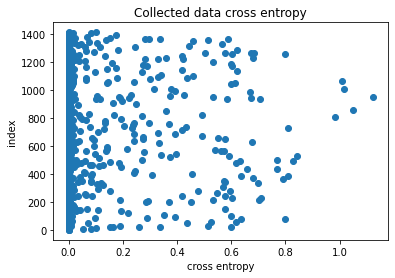

In [12]:
x_value = []
for i in range(len(collect_Cce)) :
  x_value.append(i)

plt.scatter(collect_Cce, x_value)
plt.title('Collected data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

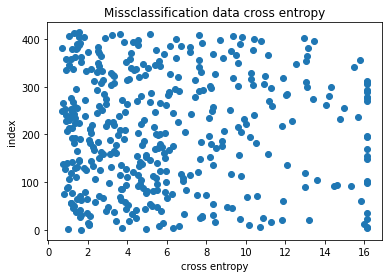

In [13]:
X_value = []
for i in range(len(missclassification_Cce)) :
  X_value.append(i)

plt.scatter(missclassification_Cce, X_value)
plt.title('Missclassification data cross entropy')
plt.ylabel('index')
plt.xlabel('cross entropy')
plt.show()

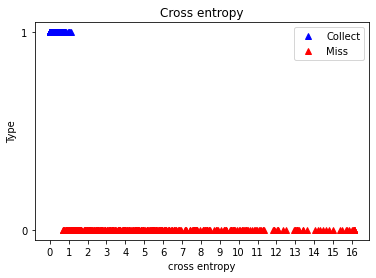

In [14]:
Y = []
for i in range(len(collect_Cce)) :
  Y.append(1)
y = []
for i in range(len(missclassification_Cce)) :
  y.append(0)

values = [0, 1, 2, 3, 4, 5, 6, 7, 8 ,9, 10, 11, 12 ,13, 14, 15, 16]

plt.plot(collect_Cce, Y, 'b^', missclassification_Cce, y, 'r^')
plt.title('Cross entropy')
plt.ylabel('Type')
plt.xlabel('cross entropy')
plt.legend(['Collect', 'Miss'])
plt.yticks([1,0])
plt.xticks(values)

plt.show()

In [15]:
cnt = 0

for i in collect_Cce : 
  if i < 0.0001 :
    cnt = cnt + 1
print(cnt)
print(cnt/len(collect_Cce))

853
0.6032531824611033


In [16]:
def static_Threshold() :
  threshold = [0.0000001, 0.000001, 0.00001, 0.00005, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
  return threshold

In [17]:
staticThreshold = static_Threshold()
print(staticThreshold)

[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]


In [18]:
def dynamic_Threshold(missclassification_Cce) :
  alpha = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
  value = min(missclassification_Cce)
  threshold = []
  print(value)

  for a in alpha :
    threshold.append(a * value)
  return threshold

In [19]:
dynamicThreshold = dynamic_Threshold(missclassification_Cce)
print(dynamicThreshold)

0.70609003
[0.03530450165271759, 0.07060900330543518, 0.14121800661087036, 0.21182700991630554, 0.2824360132217407, 0.3530450165271759]


In [20]:
def detection(threshold, cce, collect) : 
  PMD = []
  for i in collect :
    if cce[i] > threshold :
        PMD.append(i)
  return PMD

In [21]:
def detection_PMD(list_of_threshold, cce, collect):
  PMD_by_threshold = []

  for th in list_of_threshold :
    PMD_by_threshold.append(detection(th, cce, collect))
  return PMD_by_threshold

In [22]:
import cv2

In [23]:
def rotate_img_set(data_set, angle) : # 10' ~ 90'
  rotated_img = []
  print("rotate " + str(angle) + "degree")
  for img in data_set :
    m = cv2.getRotationMatrix2D((64, 64), angle, 1)
    new_img = cv2.warpAffine(img, m, (128, 128), cv2.INTER_AREA, borderMode = 1)
    rotated_img.append(new_img)
    
  return rotated_img

In [24]:
def img_trim(img, size) :
  w = 128
  h = 128
  new_img = img[size:size+h, size:size+w]
  return new_img

In [25]:
def size_Adjust(x_test, rate) :

  new_data_set = []
  if rate > 1 : # aggmentation
    print("augmentation " + str(rate) + "%")
    size = round(128*rate/2 - 64)
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_LINEAR)
      new_img = img_trim(new_img, size)
      new_data_set.append(new_img)
  else :  # reduction
    print("reduction " + str(rate) + "%")
    size = round(64 * (1-rate))
    for img in x_test :
      new_img = cv2.resize(img, None, fx = rate, fy = rate, interpolation = cv2.INTER_AREA)
      new_img = np.pad(new_img, ((size, size), (size, size), (0, 0)), mode = 'edge')
      new_img = cv2.resize(new_img, (128, 128), interpolation = cv2.INTER_AREA)
      new_data_set.append(new_img)

  return new_data_set

In [26]:
def get_MD(y_pred, new_y_pred, y_test) : # 기존 예측, 변형된 데이터 예측, 정답
  MD = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) and np.argmax(new_y_pred[i]) != np.argmax(y_test[i]) :
      MD.append(i)
  print("    Find MD : " + str(len(MD)))
  return MD

In [27]:
def calc_Acc(y_pred, y_test) :
  cnt = 0
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) :
      cnt = cnt + 1
  acc = cnt/len(y_pred)
  print("  Acc : " + str(acc))
  return acc

In [28]:
def get_Collect(y_pred, y_test) :
  c = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) == np.argmax(y_test[i]) :
      c.append(i)
  return c

In [29]:
def get_Miss(y_pred, y_test) :
  c = []
  for i in range(len(y_pred)) :
    if np.argmax(y_pred[i]) != np.argmax(y_test[i]) :
      c.append(i)
  return c

In [30]:
def get_data(MD, PMD) :
  return len(set(MD) &set(PMD))

In [31]:
def get_PMD_Precision(MD, PMD) :
  print("        PMD : " + str(len(PMD)))
  print("        MD : " + str(len(MD)))

  precision = get_data(MD, PMD)/len(PMD)
  print("        Precision : " + str(precision))
  return precision

In [32]:
def get_PMD_Recall(MD, PMD) :
  recall = get_data(MD, PMD)/len(MD)
  print("        Recall : " + str(recall))
  return recall

In [33]:
def ret(ce, list_of_threshold, c) :
  PMD = []

  for threshold in list_of_threshold :
    temp = []
    for i in c :
      if ce[i] >= threshold :
        temp.append(i)
    PMD.append(temp)
  
  return PMD

In [50]:
def get_Result(staticThreshold, dynamicThreshold, data_set, y_test, y_pred) : #
  Stp = []   # [ th = 0.1_pre1, th = 0.2_pre2, ... , th = 0.9_pre9 ] 
  Dtp = []   # [ th = min_pre1, th = 95%_pre2, ... , th = 99%_pre4 ]
  Str = []   # [ th = 0.1_rec1, th = 0.2_rec2, ... , th = 0.9_rec9 ] 
  Dtr = []   # [ th = min_rec1, th = 95%_rec2, ... , th = 99%_rec4 ] 
  Sra = []   # static robust Acc
  Dra = []   # dynamic robust Acc
  st = 1
  dt = 1

  new_y_pred = model.predict(data_set)

  acc = calc_Acc(new_y_pred, y_test)
  collect = get_Collect(new_y_pred, y_test)
  miss = get_Miss(new_y_pred, y_test)

  before_collect = get_Collect(y_pred, y_test)
  num_of_collect = len(before_collect)
  MD = list(set(miss) & set(before_collect))

  PMD_By_Static_Threshold = ret(cce, staticThreshold, before_collect)
  PMD_By_Dynamic_Threshold = ret(cce, dynamicThreshold, before_collect)

  for PMD in PMD_By_Static_Threshold :
    print("        " + str(st) + "st static threshold")
    st = st + 1
    ra = (num_of_collect - len(PMD))/len(y_test)
    print("        robust Accuracy : " + str(ra))
    Sra.append(ra)
    Stp.append(get_PMD_Precision(MD, PMD))
    Str.append(get_PMD_Recall(MD, PMD))
    print()

  print("      " + "dynamic threshold")
  for PMD in PMD_By_Dynamic_Threshold :
    print("        " + str(dt) + "st dynamic threshold")
    dt = dt + 1
    ra = (num_of_collect - len(PMD))/len(y_test)
    print("        robust Accuracy : " + str(ra))
    Dra.append(ra)
    Dtp.append(get_PMD_Precision(MD, PMD))
    Dtr.append(get_PMD_Recall(MD, PMD))
    print()

  return Stp, Dtp, Str, Dtr, Sra, Dra

In [51]:
def get_Avg_Result(lists) : #
  x = len(lists[0]) # static = 9, dynamic = 4
  y = len(lists)    # aggmentation, reduction = 4, rotate = 9
  Avg = []

  for i in range(x) :
    temp = 0
    for j in range(y) :
      temp = temp + lists[j][i]
    Avg.append(temp/y)
  return Avg

In [52]:
def validation(staticThreshold, dynamicThreshold, y_pred, y_test, list_of_rate, rotated = False) : #

  stp_Result = []
  dtp_Result = []
  str_Result = []
  dtr_Result = []
  sra_Result = []
  dra_Result = []

  for rate in list_of_rate :
    if rotated :
      data_set = rotate_img_set(x_test, rate)
    else :
      data_set = size_Adjust(x_test, rate)
    data_set = np.array(data_set)

    Stp, Dtp, Str, Dtr, Sra, Dra = get_Result(staticThreshold, dynamicThreshold, data_set, y_test, y_pred)
    stp_Result.append(Stp)
    dtp_Result.append(Dtp)
    str_Result.append(Str)
    dtr_Result.append(Dtr)
    sra_Result.append(Sra)
    dra_Result.append(Dra)

  stp_Result = get_Avg_Result(stp_Result)
  dtp_Result = get_Avg_Result(dtp_Result)
  str_Result = get_Avg_Result(str_Result)
  dtr_Result = get_Avg_Result(dtr_Result)
  sra_Result = get_Avg_Result(sra_Result)
  dra_Result = get_Avg_Result(dra_Result)
  return stp_Result, dtp_Result, str_Result, dtr_Result, sra_Result, dra_Result

In [53]:
def print_list(l) :
  for element in l :
    print(element)

In [64]:
def print_Result(stp_Result, dtp_Result, str_Result, dtr_Result, comments, staticThreshold, dynamicThreshold, Sra, Dra) :
  print(comments)
  print(staticThreshold)
  print("Static threshold precision")
  print_list(stp_Result)
  print()
  print("Static threshold recall")
  print_list(str_Result)
  print()
  print("Static threshold robust Accuracy")
  print_list(Sra)
  print()
  print(dynamicThreshold)
  print("Dynamic threshold precision")
  print_list(dtp_Result)
  print()
  print("Dynamic threshold recall")
  print_list(dtr_Result)
  print()
  print("Dynamic threshold robust Accuracy")
  print_list(Dra)

In [55]:
list_of_ag_rate = [1.1, 1.2, 1.3, 1.4]
list_of_rd_rate = [0.9, 0.8, 0.7, 0.6]
list_of_degree = [10, 20, 30, 40, 50, 60 ,70, 80 ,90]

In [56]:
rot_Stp, rot_Dtp, rot_Str, rot_Dtr, rot_Sra, rot_Dra = validation(staticThreshold, dynamicThreshold, y_pred, y_test, list_of_degree, True)   ## rotated

rotate 10degree
  Acc : 0.7484964461454346
        1st static threshold
        robust Accuracy : 0.0
        PMD : 1414
        MD : 98
        Precision : 0.06930693069306931
        Recall : 1.0

        2st static threshold
        robust Accuracy : 0.3373428102788409
        PMD : 797
        MD : 98
        Precision : 0.12296110414052698
        Recall : 1.0

        3st static threshold
        robust Accuracy : 0.40896664844177144
        PMD : 666
        MD : 98
        Precision : 0.14714714714714713
        Recall : 1.0

        4st static threshold
        robust Accuracy : 0.4527063969382176
        PMD : 586
        MD : 98
        Precision : 0.16723549488054607
        Recall : 1.0

        5st static threshold
        robust Accuracy : 0.466375068343357
        PMD : 561
        MD : 98
        Precision : 0.17290552584670232
        Recall : 0.9897959183673469

        6st static threshold
        robust Accuracy : 0.523236741388737
        PMD : 457
        MD : 98

In [57]:
ag_Stp, ag_Dtp, ag_Str, ag_Dtr, ag_Sra, ag_Dra = validation(staticThreshold, dynamicThreshold, y_pred, y_test, list_of_ag_rate, False)    ## augmentation

augmentation 1.1%
  Acc : 0.7594313832695462
        1st static threshold
        robust Accuracy : 0.0
        PMD : 1414
        MD : 85
        Precision : 0.060113154172560114
        Recall : 1.0

        2st static threshold
        robust Accuracy : 0.3373428102788409
        PMD : 797
        MD : 85
        Precision : 0.09410288582183186
        Recall : 0.8823529411764706

        3st static threshold
        robust Accuracy : 0.40896664844177144
        PMD : 666
        MD : 85
        Precision : 0.1021021021021021
        Recall : 0.8

        4st static threshold
        robust Accuracy : 0.4527063969382176
        PMD : 586
        MD : 85
        Precision : 0.10921501706484642
        Recall : 0.7529411764705882

        5st static threshold
        robust Accuracy : 0.466375068343357
        PMD : 561
        MD : 85
        Precision : 0.1140819964349376
        Recall : 0.7529411764705882

        6st static threshold
        robust Accuracy : 0.523236741388737
  

In [58]:
rd_Stp, rd_Dtp, rd_Str, rd_Dtr, rd_Sra, rd_Dra = validation(staticThreshold, dynamicThreshold, y_pred, y_test, list_of_rd_rate, False)   ## reduction

reduction 0.9%
  Acc : 0.7528704209950793
        1st static threshold
        robust Accuracy : 0.0
        PMD : 1414
        MD : 89
        Precision : 0.06294200848656294
        Recall : 1.0

        2st static threshold
        robust Accuracy : 0.3373428102788409
        PMD : 797
        MD : 89
        Precision : 0.11166875784190715
        Recall : 1.0

        3st static threshold
        robust Accuracy : 0.40896664844177144
        PMD : 666
        MD : 89
        Precision : 0.13363363363363365
        Recall : 1.0

        4st static threshold
        robust Accuracy : 0.4527063969382176
        PMD : 586
        MD : 89
        Precision : 0.15017064846416384
        Recall : 0.9887640449438202

        5st static threshold
        robust Accuracy : 0.466375068343357
        PMD : 561
        MD : 89
        Precision : 0.1568627450980392
        Recall : 0.9887640449438202

        6st static threshold
        robust Accuracy : 0.523236741388737
        PMD : 457
  

In [65]:
print_Result(rot_Stp, rot_Dtp, rot_Str, rot_Dtr, "Rotation", staticThreshold, dynamicThreshold, rot_Sra, rot_Dra)

Rotation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Static threshold precision
0.6589658965896591
0.685626655513732
0.6931931931931933
0.7076222980659841
0.7104377104377105
0.7225869195234621
0.7288676236044658
0.7497116493656285
0.7642031171442935
0.7826350941105039
0.7941176470588236
0.7862433862433861
0.7981029810298103
0.7863247863247862

Static threshold recall
1.0
0.6422006562279106
0.5615303357545677
0.5173556743099282
0.5011051886232583
0.4316152168011839
0.4055781556589695
0.309692716408984
0.2546057956581321
0.22336828264621042
0.16910640296129273
0.1327750110948488
0.10944630325010268
0.0849402279411083

Static threshold robust Accuracy
0.0
0.3373428102788409
0.4089666484417714
0.45270639693821757
0.46637506834335707
0.523236741388737
0.5445598687807545
0.6150902132312739
0.652268999453253
0.6730453799890651
0.6987424822307273
0.7156916347731002
0.7282668124658284
0.7375615090213231

[0.03530450165271759, 0.07060900330543518, 0.1

In [66]:
print_Result(ag_Stp, ag_Dtp, ag_Str, ag_Dtr, "Augmentation", staticThreshold, dynamicThreshold, ag_Sra, ag_Dra)

Augmentation
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Static threshold precision
0.1440947666195191
0.21831869510664995
0.23123123123123124
0.24530716723549487
0.25089126559714797
0.27571115973741794
0.29425837320574166
0.32871972318339104
0.3495475113122172
0.3825136612021858
0.4154411764705882
0.4238095238095238
0.4603658536585366
0.4807692307692308

Static threshold recall
1.0
0.8712547029038167
0.7805961134127073
0.732577659660886
0.7215584257813901
0.6583240281519245
0.6454553208586088
0.5158027777228907
0.4277904347272444
0.3969739572012883
0.32850969268385144
0.26424213816456305
0.22415020970505173
0.1887127783595803

Static threshold robust Accuracy
0.0
0.3373428102788409
0.40896664844177144
0.4527063969382176
0.466375068343357
0.523236741388737
0.5445598687807545
0.6150902132312739
0.6522689994532531
0.6730453799890651
0.6987424822307272
0.7156916347731
0.7282668124658284
0.7375615090213231

[0.03530450165271759, 0.07060900330543

In [67]:
print_Result(rd_Stp, rd_Dtp, rd_Str, rd_Dtr, "Reduction", staticThreshold, dynamicThreshold, rd_Sra, rd_Dra)

Reduction
[1e-07, 1e-06, 1e-05, 5e-05, 0.0001, 0.0005, 0.001, 0.01, 0.05, 0.1, 0.2, 0.3, 0.4, 0.5]
Static threshold precision
0.18193069306930693
0.2936010037641154
0.33445945945945943
0.3613481228668942
0.3698752228163993
0.41630196936542674
0.4354066985645933
0.5051903114186851
0.5554298642533937
0.5683060109289617
0.5827205882352942
0.611904761904762
0.6158536585365854
0.6730769230769231

Static threshold recall
1.0
0.950162910670649
0.923577925604127
0.8951682037420642
0.8842124611409239
0.8395801478476426
0.817843571725146
0.6923285086326028
0.6073885026118602
0.521343475819513
0.4083536126624998
0.3305618461997629
0.2617228276074333
0.2298662440831875

Static threshold robust Accuracy
0.0
0.3373428102788409
0.40896664844177144
0.4527063969382176
0.466375068343357
0.523236741388737
0.5445598687807545
0.6150902132312739
0.6522689994532531
0.6730453799890651
0.6987424822307272
0.7156916347731
0.7282668124658284
0.7375615090213231

[0.03530450165271759, 0.07060900330543518, 0.1412180